<a href="https://colab.research.google.com/github/shreeya-la/audio-ml/blob/main/yamnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Download ESC50

In [1]:
#!pip install tensorflow --upgrade

In [2]:
# !pip uninstall tensorflow
# !pip uninstall tensorflow-io

In [3]:
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import seaborn as sns

from tensorflow.keras.layers import Layer
from sklearn.metrics import confusion_matrix, classification_report
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.6 MB/s eta 0:00:00


In [4]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2024-12-04 19:30:27--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-12-04 19:30:27--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-12-04 19:30:27--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   

In [5]:
!unzip -qq master.zip

In [6]:
%cd ESC-50-master
# create a dataframe
esc50_data = pd.read_csv('meta/esc50.csv')
esc50_data.head()

/content/ESC-50-master


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A
46,1-15689-B-4.wav,1,4,frog,False,15689,B
49,1-16568-A-3.wav,1,3,cow,False,16568,A
64,1-17585-A-7.wav,1,7,insects,False,17585,A
69,1-17970-A-4.wav,1,4,frog,False,17970,A
70,1-18074-A-6.wav,1,6,hen,False,18074,A


In [8]:
def preprocess_wav(filename, target_sr=16000):
    filename = 'audio/' + filename
    # Load the .wav file using librosa
    audio, sampling_rate = librosa.load(filename, sr=None)

    # Resample to target sample rate (16kHz)
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sr)

    # If audio has more than 1 channel, convert to mono
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    # Convert to float32 TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    return audio_tensor

In [9]:
# @tf.function
# def load_wav_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     file_contents = tf.io.read_file(filename)
#     wav, sample_rate = tf.audio.decode_wav(
#           file_contents,
#           desired_channels=1)
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

# YAMNet

In [10]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_model_handle)

In [11]:
# get a sample .wav file
sample_file = esc50_animals.iloc[0]['filename']
esc_single_waveform = preprocess_wav(sample_file)

# # plot and display
# _ = plt.plot(esc_single_waveform)
# display.Audio(esc_single_waveform, rate=16000)

esc_single_waveform.shape

TensorShape([80000])

In [12]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [13]:
# to find the top-scored class, take the maximum of the 521 aggregated scores.
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Silence


In [14]:
# results = []

# # for each file in the esc50_animals
# for index, row in esc50_animals.iterrows():

#     #preprocess
#     filename = row['filename']
#     wav = preprocess_wav(filename)

#     #run yamnet
#     scores, embeddings, spectrogram = yamnet(wav)

#     # convert scores to numpy array and find the inferred class
#     scores_np = scores.numpy()
#     predicted = class_names[scores_np.mean(axis=0).argmax()]

#     # Store the result
#     results.append({
#         #'filename': filename,
#         'predicted class': predicted.lower(),
#         'true class': row['category']
#     })

# results_df = pd.DataFrame(results)

In [15]:
# results_df.head(20)

# Sequential Model

In [16]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [17]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A


In [18]:
# convert columns to numpy arrays
filenames = esc50_animals['filename']
targets = esc50_animals['target']
folds = esc50_animals['fold']

esc50 = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
esc50.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
# def load_wav_for_map(filename, label, fold):
#     return preprocess_wav(filename), label, fold

# esc50 = esc50.map(load_wav_for_map)
# esc50.element_spec

In [20]:
def load_wav_for_map(filename, label, fold):
    def _load_wav(filename):
        filename_str = filename.numpy().decode('utf-8')
        return preprocess_wav(filename_str)

    # wrap the python-based _load_wav function
    audio = tf.py_function(_load_wav, [filename], tf.float32)
    return audio, label, fold

esc50 = esc50.map(load_wav_for_map)
esc50.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [21]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  # run YAMNet to extract embedding from the wav data
  scores, embeddings, spectrogram = yamnet(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
esc50 = esc50.map(extract_embedding).unbatch()
esc50.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [22]:
# clips from the same original source should always be in the same fold
cached_ds = esc50.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

In [23]:
# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
num_classes = len(animals)

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)
], name='my_model')

#my_model.summary()

In [25]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [26]:
history = my_model.fit(train_ds,
                       epochs=40,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/40
     72/Unknown 21s 211ms/step - accuracy: 0.5937 - loss: 1.7215

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.5999 - loss: 1.6959 - val_accuracy: 0.7738 - val_loss: 0.7312
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7745 - loss: 0.7873 - val_accuracy: 0.7800 - val_loss: 0.6727
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8209 - loss: 0.6116 - val_accuracy: 0.7613 - val_loss: 0.7470
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8431 - loss: 0.5049 - val_accuracy: 0.7600 - val_loss: 0.7369
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8573 - loss: 0.4833 - val_accuracy: 0.7362 - val_loss: 0.7146
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8637 - loss: 0.4233 - val_accuracy: 0.7663 - val_loss: 0.7414
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8839 - loss: 0.3558 - val_accuracy: 0.7387 - val_loss: 0.7512
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8723 - loss: 0.3813 - val_accuracy: 0.7600 - val_loss: 

In [27]:
# evaluate the model
loss, accuracy = my_model.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5849 - loss: 2.4194
Test accuracy: 0.6862


# Confusion Matrix

In [28]:
# with early stopping
# 20 epochs: 0.8188 (stopped at 13)
# 40 epochs: 0.6750 (stopped at 8)

In [29]:
# get the true labels and predicted labels
true_labels = []
predicted_labels = []

for embedding, label in test_ds:
    true_labels.append(label.numpy())  # true label
    predictions = my_model.predict(embedding)  #  model predictions
    predicted_labels.append(np.argmax(predictions, axis=1))  # convert predictions to class labels

# convert lists to arrays
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


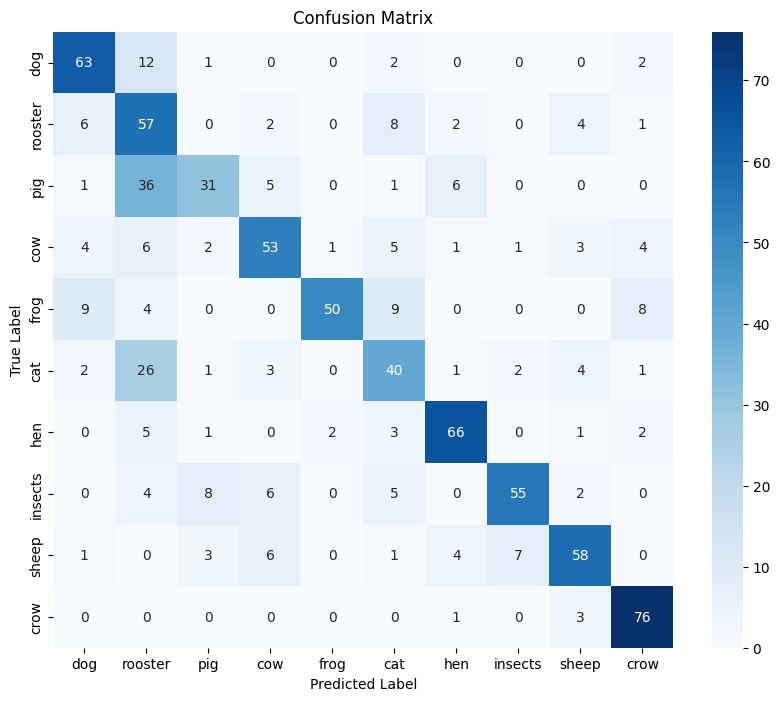

In [30]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=animals, yticklabels=animals)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
result = my_model(embeddings).numpy()

inferred_class = animals[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: dog


# One Function

In [32]:
# one function to preprocess and predict

def full_yamnet(filename):
    # preprocess the .wav file
    esc_waveform = preprocess_wav(filename)

    # run YAMNet and get the embedding
    scores, embeddings, spectrogram = yamnet(esc_waveform)

    # use the full classification model
    predictions =  my_model(embeddings).numpy()

    # Get the predicted class label
    predicted_label = animals[predictions.mean(axis=0).argmax()]

    print(f"Predicted Category: {predicted_label}")

    # get the true category
    category = esc50_animals[esc50_animals['filename'] == filename]['category'].values[0]
    print(f"True Category: {category}")

In [33]:
full_yamnet(esc50_animals.iloc[20]['filename'])

Predicted Category: pig
True Category: pig


In [34]:
esc50_test = esc50_animals[esc50_animals.fold == 5]

In [35]:
results = []
count = 0

# for each file in the esc50_animals
for index, row in esc50_test.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    # preprocess the .wav file
    esc_waveform = preprocess_wav(filename)

    # run YAMNet and get the embedding
    scores, embeddings, spectrogram = yamnet(esc_waveform)

    # use the full classification model
    predictions =  my_model(embeddings).numpy()

    # Get the predicted class label
    predicted_label = animals[predictions.mean(axis=0).argmax()]

    # true label
    category = esc50_animals[esc50_animals['filename'] == filename]['category'].values[0]


    if(predicted_label == category):
        count += 1

    # Store the result
    results.append({
        'predicted class': predicted_label,
        'true class': category
    })

results_df = pd.DataFrame(results)

In [36]:
print("Accuracy: ", count / 80)

Accuracy:  0.925


# Save and Quantize Model

In [37]:
saved_model_path = './yamnet_tutorial'

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

class YAMNetLayer(Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YAMNetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')

    def call(self, inputs):
        # reshape the input to match YAMNet's expected 1D tensor input
        reshaped_inputs = tf.reshape(inputs, (-1,))
        # get embeddings from YAMNet
        _, embeddings_output, _ = self.yamnet_layer(reshaped_inputs)
        return embeddings_output

input_segment = tf.keras.layers.Input(shape=(80000,), dtype=tf.float32, name='audio')
embedding_extraction_layer = YAMNetLayer(yamnet_model_handle)
embeddings_output = embedding_extraction_layer(input_segment)

# pass embeddings to sequential model
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_segment, serving_outputs)
# tf.saved_model.save(serving_model, saved_model_path)

In [38]:
#tf.keras.utils.plot_model(serving_model)

In [39]:
%cd /content

/content


In [40]:
# Convert the model to TFLite.
converter = tf.lite.TFLiteConverter.from_keras_model(serving_model)
tflite_model = converter.convert()

# Save the model.
with open('./yamnet_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpeu5z1khu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80000), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(10,), dtype=tf.float32, name=None)
Captures:
  137544677123776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205584: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137544672206640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672206288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204000: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137544672205056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672203824: TensorSpec

In [41]:
# Convert the model to TFLite AND quantize weights
converter = tf.lite.TFLiteConverter.from_keras_model(serving_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('./yamnet_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

Saved artifact at '/tmp/tmpb8rg3uuu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80000), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(10,), dtype=tf.float32, name=None)
Captures:
  137544677123776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205584: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137544672206640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672206288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672205408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204000: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137544672205056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672204352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137544672203824: TensorSpec

# Test saved model

In [42]:
# load
tflite_model_path = 'yamnet_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

In [43]:
%cd /content/ESC-50-master

/content/ESC-50-master


In [44]:
test_num = 11
sample_file = esc50_animals.iloc[test_num]['filename']
input_data = preprocess_wav(sample_file)
input_data = tf.expand_dims(input_data, axis=0)

In [45]:
# allocate the tensors
interpreter.allocate_tensors()

# get input details and set the input tensor
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# run inference
interpreter.invoke()

In [46]:
# get and process the output
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data)

print("True Class Label:", esc50_animals.iloc[test_num]['category'])

predicted_label = animals[predicted_index]
print("Predicted Class Label:", predicted_label)

True Class Label: frog
Predicted Class Label: frog


In [47]:
results = []
count = 0

# for each file in the esc50_animals
for index, row in esc50_animals.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    input_data = tf.expand_dims(wav, axis=0)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = np.argmax(output_data)

    if(predicted_index == row['target']):
        count += 1

    # Store the result
    results.append({
        'predicted class': animals[predicted_index],
        'true class': row['category']
    })

results_df = pd.DataFrame(results)

In [48]:
print("Accuracy of entire set: ", count / 400)

Accuracy of entire set:  0.9725


In [49]:
results = []
count = 0

# for each file in the esc50_animals
for index, row in esc50_test.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    input_data = tf.expand_dims(wav, axis=0)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = np.argmax(output_data)

    if(predicted_index == row['target']):
        count += 1

    # Store the result
    results.append({
        'predicted class': animals[predicted_index],
        'true class': row['category']
    })

results_df = pd.DataFrame(results)

In [50]:
print("Accuracy of just test set: ", count / 80)

Accuracy of just test set:  0.925


# Test Quant Model

In [51]:
%cd /content

/content


In [52]:
# load
tflite_model_path_q = 'yamnet_quant_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path_q)

In [53]:
# allocate the tensors
interpreter.allocate_tensors()

# get input details and set the input tensor
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# run inference
interpreter.invoke()

In [54]:
%cd /content/ESC-50-master

/content/ESC-50-master


In [63]:
results_q = []
count_q = 0

# for each file in the esc50_animals
for index, row in esc50_animals.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    input_data = tf.expand_dims(wav, axis=0)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = np.argmax(output_data)

    if(predicted_index == row['target']):
        count_q += 1

    # Store the result
    results_q.append({
        'predicted class': animals[predicted_index],
        'true class': row['category']
    })

results_df = pd.DataFrame(results_q)

In [64]:
print("Accuracy of entire set:", count_q / 400)

Accuracy of entire set: 0.965


In [65]:
results_q = []
count_q = 0

# for each file in the esc50_animals
for index, row in esc50_test.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    input_data = tf.expand_dims(wav, axis=0)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_index = np.argmax(output_data)

    if(predicted_index == row['target']):
        count_q += 1

    # Store the result
    results_q.append({
        'predicted class': animals[predicted_index],
        'true class': row['category']
    })

results_df = pd.DataFrame(results_q)

In [70]:
print("Accuracy of test set:", count_q / 80)

Accuracy of test set: 0.9125


# Quant Aware Training - Does not work

Need to use a different version of Keras; see https://colab.research.google.com/drive/1elY1m6JPPiJJ-EOItlLtBMNqd1zKEzDO#scrollTo=9W0F4i3OwvPl

In [57]:
quantize_model = tfmot.quantization.keras.quantize_model

In [58]:
# q_aware stands for for quantization aware.
q_aware_model = quantize_model(my_model)

ValueError: `to_quantize` can only either be a keras Sequential or Functional model.

In [ ]:
# should be <class 'keras.src.engine.sequential.Sequential'>
print(type(my_model))